In [338]:
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os


In [79]:
BASE_DIR = Path(os.getcwd()).resolve().parent
PAS_detailed_path = os.path.join(BASE_DIR.parent, 'PAS_detailed2.pkl')
PAS_detailed1_path = os.path.join(BASE_DIR.parent, 'PAS_detailed.pkl')


In [80]:
PAS_detailed = pd.read_pickle(PAS_detailed_path)
PAS_detailed1 = pd.read_pickle(PAS_detailed1_path)

The following part is used to fix boroughs and borough names in PAS detailed file

In [ ]:
#fixing borough, api does not work sometimes
ward_borough_old = {}
for i, ward in enumerate(PAS_detailed['ward'].unique().tolist()):
    print(i)
    borough = requests.get(f'https://findthatpostcode.uk/areas/{ward}.json').json()['data']['attributes']['parent']
    ward_borough_old[ward] = borough

borough_name = {}
for i, borough in enumerate(PAS_detailed['Borough'].unique().tolist()):
    print(i)
    borough_name = requests.get(f'https://findthatpostcode.uk/areas/{borough}.json').json()['data']['attributes']['name']
    ward_borough_old[borough] = borough_name

In [81]:
#if api does not work, use this code
with open("ward_borough_old.json", "r") as file:
    ward_borough_old = json.load(file)
with open("borough_name.json", "r") as file:
    borough_name = json.load(file)

In [82]:
PAS_detailed['Borough'] = PAS_detailed['ward'].apply(lambda x: ward_borough_old[x])
PAS_detailed['Borough name'] = PAS_detailed['Borough'].apply(lambda x: ward_borough_old[x])
# PAS_detailed1['Borough'] = PAS_detailed1['ward'].apply(lambda x: ward_borough_old[x])
# PAS_detailed1['Borough name'] = PAS_detailed1['Borough'].apply(lambda x: ward_borough_old[x])

In [83]:
PAS_detailed = PAS_detailed.replace({"SQ109CAA":{'Residents Association': np.nan, 'Other': np.nan}})
PAS_detailed["Year"] = PAS_detailed['Year-Month'].apply(lambda x: pd.to_datetime(x).year)
PAS_detailed["Month"] = PAS_detailed['Year-Month'].apply(lambda x: pd.to_datetime(x).month)
important_cols = ["Year-Month", "Year","Month", "ward_n", "ward", "Borough", "Borough name"]

In [12]:
def merge_columns(col1, col2):
    if col1 is None:
        return col2
    else:
        return col1

In [84]:
PAS_detailed['Ethnic group'] = PAS_detailed.apply(lambda x: merge_columns(x['NQ147r'], x['ReNQ147']), axis=1)
PAS_detailed['Age band'] = PAS_detailed.apply(lambda x: merge_columns(x['Q136r'], x['ReQ136']), axis=1)
PAS_detailed['Current Employment status'] = PAS_detailed.apply(lambda x: merge_columns(x['Q139r'], x['ReQ139']), axis=1)
PAS_detailed['Gender'] = PAS_detailed.apply(lambda x: merge_columns(x['XQ135r'], x['ReXQ135']), axis=1)
demographic_columns = ['Ethnic group','Age band','Current Employment status','Gender']

In [200]:
df_1519 = PAS_detailed[important_cols + ["BQ90D", "BQ90B", "BQ90C", "SQ109CAA", 'NQ135BD', 'Q60'] +demographic_columns][~(PAS_detailed["BQ90D"].isna())&(PAS_detailed["BQ90B"].isin(['In local area', 'Elsewhere in London']))].copy()
df_1519.loc[(df_1519['BQ90D'] == 'Yes')&(df_1519['SQ109CAA'].isna()), 'BQ90D'] = 'No'
df_1519['Reported'] = df_1519['BQ90D']
df_1519['Crime type'] = df_1519['BQ90C']
df_1519['Trust'] = df_1519['NQ135BD']
df_1519['Confidence'] = df_1519['Q60']
df_1519 = df_1519[important_cols + ["Reported", "Crime type", "Trust", "Confidence"]+demographic_columns]
df_1519 = df_1519[~(df_1519['Crime type'].isna())&~(df_1519['Trust'].isna())&~(df_1519['Confidence'].isna())]
df_1921 = PAS_detailed[important_cols + ["BQ90DA", "BQ90D", "BQ90B", "BQ90C", "SQ109CAA", 'NQ135BD', 'Q60'] +demographic_columns][~(PAS_detailed["BQ90DA"].isna())].copy()
df_1921['Reported'] = df_1921['BQ90DA']
df_1921['Crime type'] = df_1921['BQ90C']
df_1921['Trust'] = df_1921['NQ135BD']
df_1921['Confidence'] = df_1921['Q60']
df_1921 = df_1921[important_cols + ["Reported", "Crime type", "Trust", "Confidence"] +demographic_columns]
df_1921 = df_1921[~(df_1921['Crime type'].isna())&~(df_1921['Trust'].isna())&~(df_1921['Confidence'].isna())]
df_1521 = pd.concat([df_1519, df_1921])

df_1521.loc[df_1521['Crime type'] == 'Online contact that has caused fear, alarm or distress', 'Crime type'] = 'Online'
df_1521.loc[df_1521['Crime type'] == 'Knife crime - being threatened with a knife or attacked with a knife', 'Crime type'] = 'Knife crime'
df_1521.loc[df_1521['Crime type'] == 'Credit/debit card fraud ', 'Crime type'] = 'Credit/debit card fraud'

In [37]:
df_1521

,Year-Month,Year,Month,ward_n,ward,Borough,Borough name,Reported,Crime type,Trust,Confidence,Ethnic group,Age band,Current Employment status,Gender
4,2015-05-01,2015,5,Royal Hospital,E05009403,E09000020,Kensington and Chelsea,Yes,Property crime,Strongly agree,Good,White British,35-44,Working PT,Male
21,2015-06-01,2015,6,Courtfield,E05009393,E09000020,Kensington and Chelsea,No,Anti-Social Behaviour,Strongly agree,Excellent,White British,45-54,Working FT,Male
32,2015-04-01,2015,4,Holland,E05009397,E09000020,Kensington and Chelsea,Yes,Other,Tend to agree,Fair,White British,65 or over,Retired,Female
59,2015-04-01,2015,4,Brompton & Hans Town,E05009389,E09000020,Kensington and Chelsea,Yes,Property crime,Tend to agree,Very poor,White Other,65 or over,Retired,Female
61,2015-05-01,2015,5,Brompton & Hans Town,E05009389,E09000020,Kensington and Chelsea,No,Anti-Social Behaviour,Neither agree nor disagree,Good,Mixed,25-34,Working FT,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76345,2021-03-01,2021,3,Thornton Heath,E05011486,E09000008,Croydon,Yes,Property crime,Tend to agree,Very poor,NaN,NaN,NaN,NaN
76350,2021-03-01,2021,3,Churchfields,E05011238,E09000026,Redbridge,Yes,Harassment,Tend to agree,Poor,NaN,NaN,NaN,NaN
76351,2021-03-01,2021,3,Larkswood,E05000602,E09000031,Waltham Forest,Yes,Anti-Social Behaviour,Strongly disagree,Very poor,NaN,NaN,NaN,NaN
76358,2021-03-01,2021,3,River,E05000038,E09000002,Barking and Dagenham,Yes,Harassment,Tend to agree,Poor,NaN,NaN,NaN,NaN


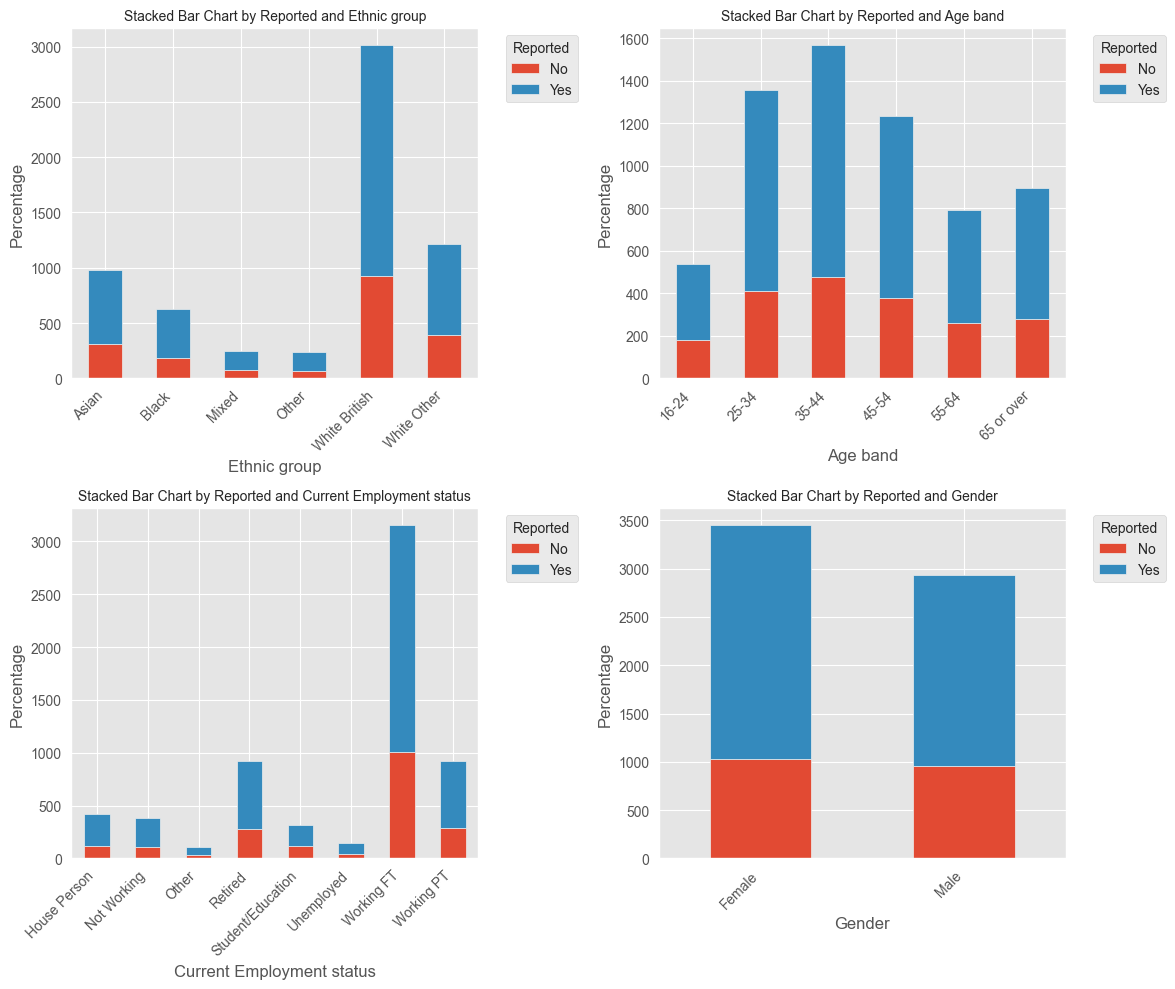

In [340]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

# Iterate over demographic columns and plot each on a different subplot
for i, demographic in enumerate(demographic_columns):
    grouped = df_1521.groupby([demographic, 'Reported']).size().unstack(fill_value=0)
    # grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
    ax = grouped.plot(kind='bar', stacked=True, ax=axes[i])  # Plot on the i-th subplot
    ax.set_title(f'Stacked Bar Chart by Reported and {demographic}', fontsize=10)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')
    ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [342]:
grouped.div(grouped.sum())

Reported,No,Yes
Gender,,
Female,0.519598,0.549875
Male,0.480402,0.450125


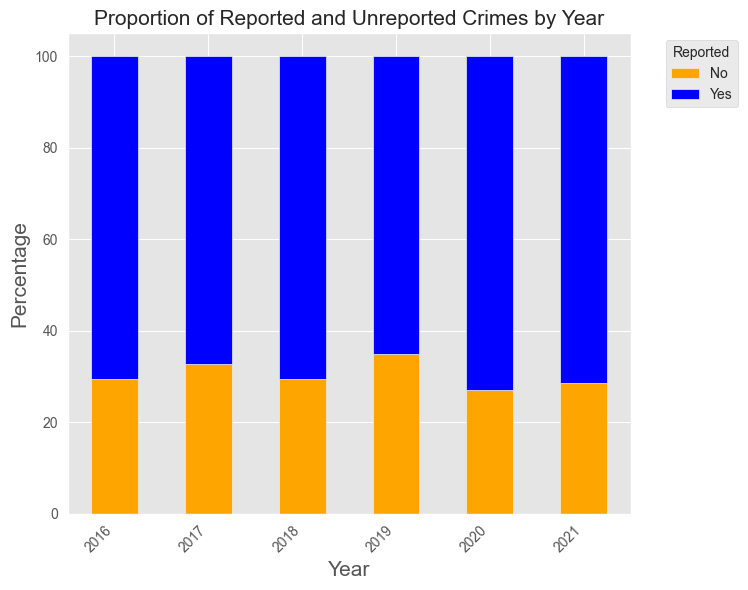

In [457]:
# Group and normalize the data
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
grouped = df_1621.groupby(['Year', 'Reported']).size().unstack(fill_value=0)
grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
plt.style.use('ggplot')
# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, color=['orange', 'blue'])

# Set the title and labels
ax.set_title('Proportion of Reported and Unreported Crimes by Year', fontsize=15)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Percentage', fontsize=15)
ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

# Add a legend
ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.savefig('byyear.png', transparent = True)
plt.show()


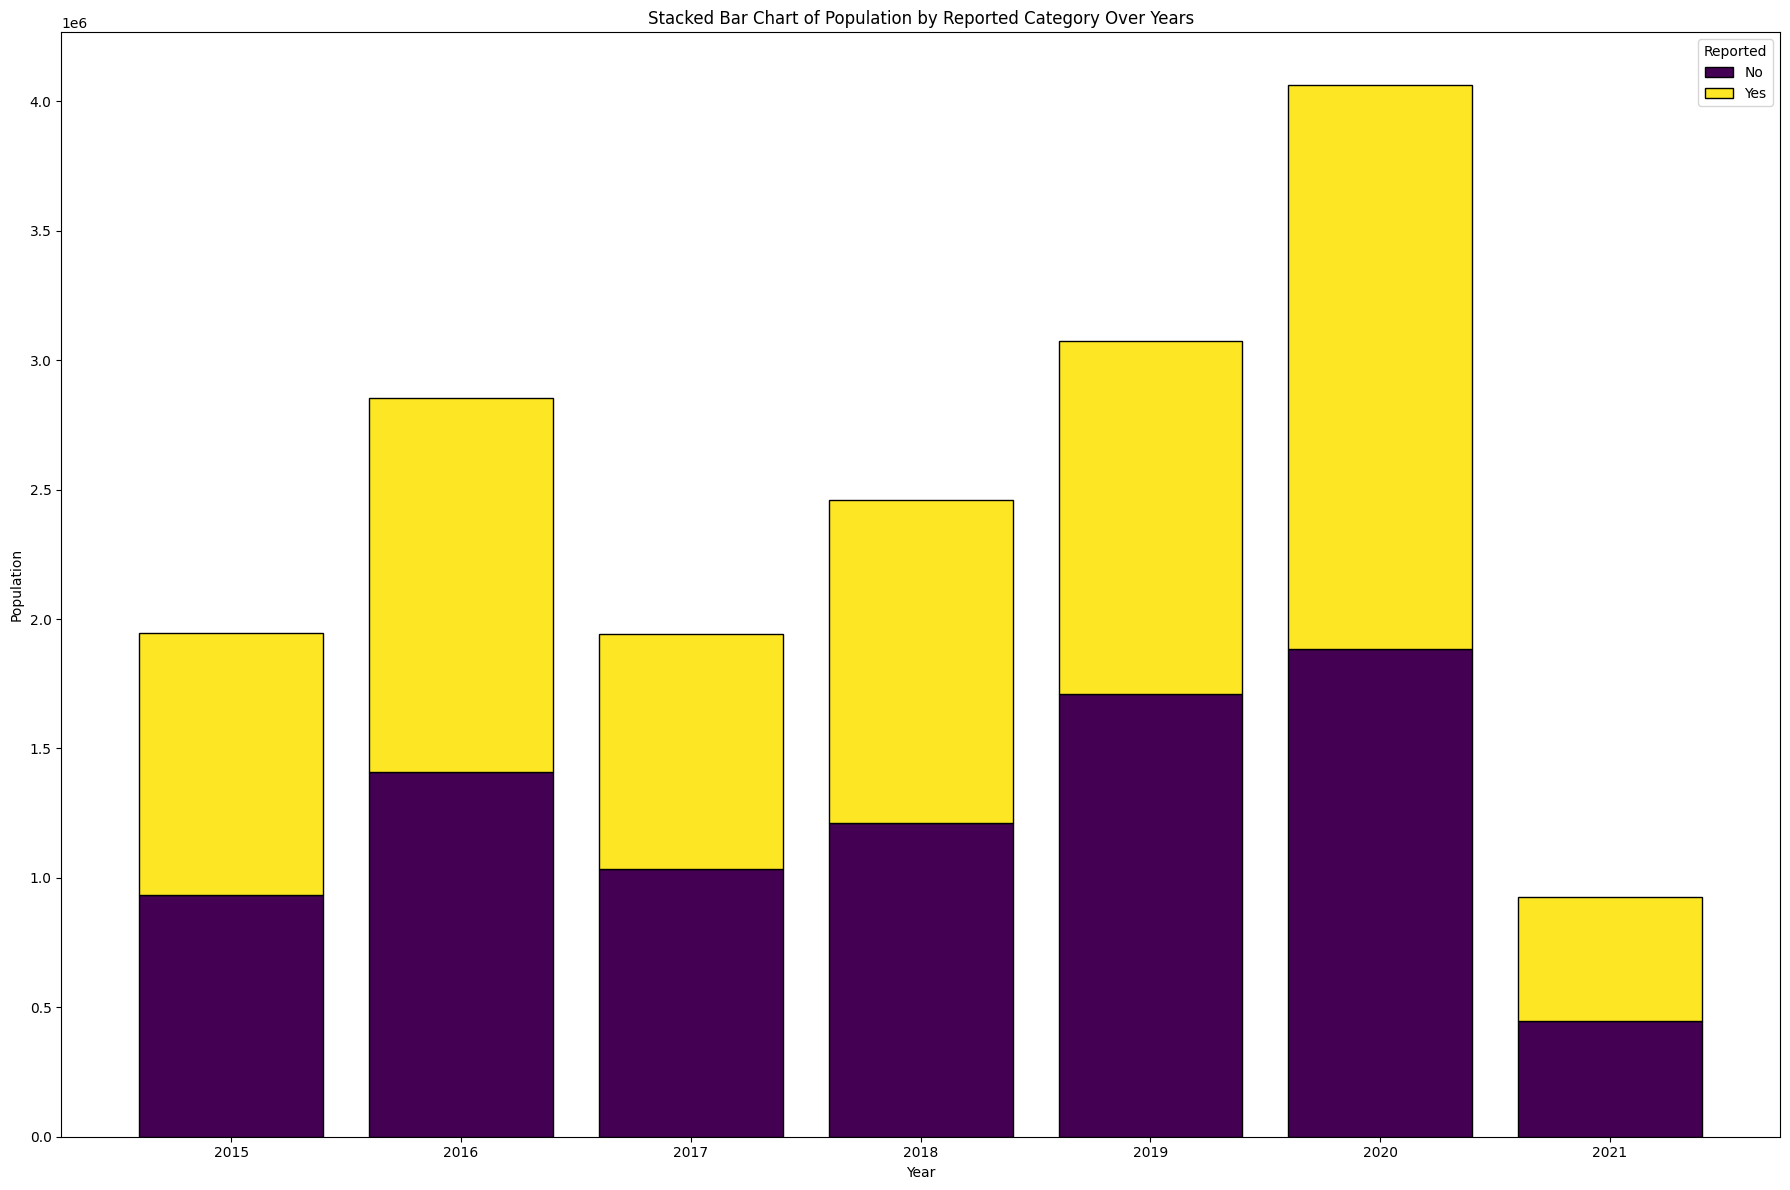

In [205]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
axs = axs.flatten()
years = df_1521['Year'].unique()
london_population = 8632850 #in 2015
for i, ax in enumerate(axs):
    grouped = df_1521[df_1521['Year']==years[i+1]].groupby(['Reported']).size()
    percentages  = grouped.div(grouped.sum(), axis=0) * 100
    pop_weighted_values = (percentages / 100) * london_population
    wedges, texts, autotexts = ax.pie(
            pop_weighted_values, labels=grouped.index, autopct=lambda p: f'{p:.1f}% or\n{int(p * london_population / 100):,} people',
            startangle=90, colors=plt.cm.viridis(np.linspace(0, 1, len(grouped))), wedgeprops={'edgecolor': 'black'}
        )
    # grouped.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colormap='viridis', legend=False)
    # ax.set_title(f'Stacked Bar Chart by Reported and {demographic}')
    ax.set_title(f'Year {years[i+1]}')
    ax.set_ylabel('')
    # plt.xticks(rotation=0)
    # ax.legend(title=demographic)
    for text in autotexts:
            text.set_color('white')
            text.set_fontsize(10)
plt.show()

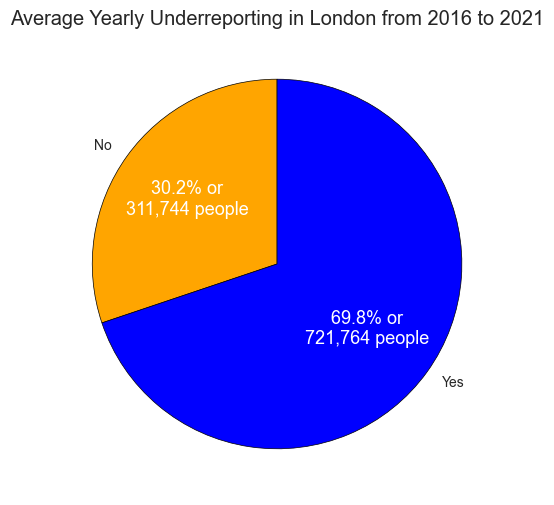

In [447]:
fig, ax = plt.subplots(figsize=(9, 6), sharey=True)
plt.style.use('ggplot')
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
years = df_1621['Year'].unique()
london_population = 8632850
were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes', 'No'])]

were_a_victim = london_population*(were_a_victim.groupby('BQ90A').size()['Yes']/were_a_victim.groupby('BQ90A').size().sum()
)

grouped = df_1621.groupby(['Reported']).size()
percentages  = grouped.div(grouped.sum(), axis=0) * 100
pop_weighted_values = (percentages / 100) * were_a_victim
wedges, texts, autotexts = ax.pie(
        pop_weighted_values, labels=pop_weighted_values.index, autopct=lambda p: f'{p:.1f}% or\n{int(p * were_a_victim / 100):,} people',
        startangle=90, wedgeprops={'edgecolor': 'black'}, colors=['orange', 'blue']
    )
# grouped.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colormap='viridis', legend=False)
# ax.set_title(f'Stacked Bar Chart by Reported and {demographic}')
ax.set_title(f'Average Yearly Underreporting in London from 2016 to 2021')
ax.set_ylabel('')
# plt.xticks(rotation=0)
# ax.legend(title=demographic)
for text in autotexts:
        text.set_color('white')
        text.set_fontsize(13)
plt.savefig('graph2.png', transparent=True)

plt.show()

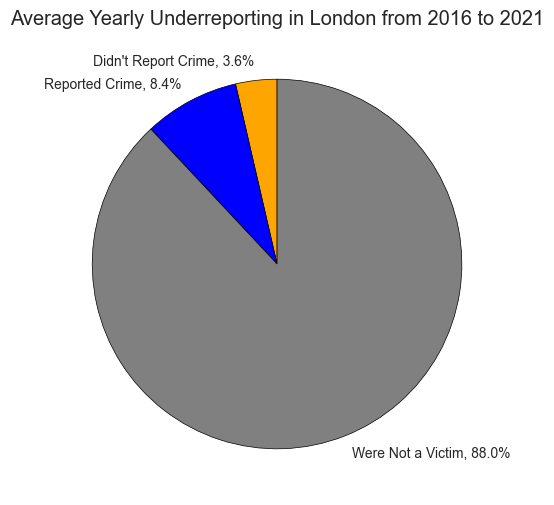

In [446]:
fig, ax = plt.subplots(figsize=(9, 6), sharey=True)
plt.style.use('ggplot')
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]
years = df_1621['Year'].unique()
london_population = 8632850
were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes', 'No'])]

were_a_victim = london_population*(were_a_victim.groupby('BQ90A').size()['Yes']/were_a_victim.groupby('BQ90A').size().sum()
)

grouped = df_1621.groupby(['Reported']).size()
percentages  = grouped.div(grouped.sum(), axis=0) * 100
pop_weighted_values = (percentages / 100) * were_a_victim
pop_weighted_values['Were Not a Victim'] = london_population - were_a_victim

pop_weighted_values['Reported Crime'] = pop_weighted_values['Yes']
pop_weighted_values["Didn't Report Crime"] = pop_weighted_values['No']
pop_weighted_values = pop_weighted_values[["Didn't Report Crime", "Reported Crime", "Were Not a Victim"]]
wedges, texts= ax.pie(
        pop_weighted_values, labels=[f'{ind}, {pop_weighted_values[ind]/pop_weighted_values.sum()*100:.1f}%' for ind in pop_weighted_values.index],
        startangle=90, wedgeprops={'edgecolor': 'black'}, colors=['orange', 'blue', 'grey']
    )
# grouped.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=90, colormap='viridis', legend=False)
# ax.set_title(f'Stacked Bar Chart by Reported and {demographic}')
ax.set_title(f'Average Yearly Underreporting in London from 2016 to 2021')
ax.set_ylabel('')
# plt.xticks(rotation=0)
# ax.legend(title=demographic)
# for text in autotexts:
#         text.set_color('white')
#         text.set_fontsize(13)
plt.savefig('graph1.png', transparent=True)
plt.show()

In [367]:
grouped.index

Index(['No', 'Yes'], dtype='object', name='Reported')

In [389]:
pop_weighted_values['Were Not a Victim']/pop_weighted_values.sum()

0.8802818746234249

In [97]:
PAS_detailed[PAS_detailed['PQ98A']=='Yes'].groupby('Year-Month').size()

Year-Month
2015-04-01    5
2015-05-01    4
2015-06-01    5
2015-07-01    2
2015-08-01    9
2015-09-01    6
2015-10-01    4
2015-11-01    2
2015-12-01    5
2016-01-01    3
2016-02-01    3
2016-03-01    3
2016-04-01    2
2016-05-01    5
2016-06-01    9
2016-07-01    4
2016-08-01    7
2016-09-01    7
dtype: int64

In [107]:
PAS_detailed[~PAS_detailed['Q62A'].isna()][['Year-Month']]

,Year-Month
0,2015-04-01
1,2015-04-01
2,2015-04-01
3,2015-04-01
4,2015-05-01
...,...
76393,2021-03-01
76394,2021-03-01
76395,2021-03-01
76396,2021-03-01


In [109]:
relied_on_to_be_there_cols = []
for col in PAS_detailed1.columns:
    if col.startswith('Q62'):
        relied_on_to_be_there_cols.append(col)
        print(col)

Q62A
Q62B
Q62C
Q62D
Q62E
Q62F
Q62TG
Q62H
Q62TI
Q62TJ


In [110]:
relied_on_to_be_there_cols

['Q62A',
 'Q62B',
 'Q62C',
 'Q62D',
 'Q62E',
 'Q62F',
 'Q62TG',
 'Q62H',
 'Q62TI',
 'Q62TJ']

In [135]:
mappings = {
    'Tend to agree': 2,
    'Strongly agree': 1,
    'Neither agree nor disagree': 0,
    'Tend to disagree': -1,
    'Strongly disagree': -2,
}

relied_df = PAS_detailed[important_cols + relied_on_to_be_there_cols + demographic_columns].copy()

In [171]:
antimapping = {}
for key, value in mappings.items():
    antimapping[value] = key

In [137]:
for col in relied_on_to_be_there_cols:
    relied_df[col] = relied_df[col].map(mappings)

In [172]:
relied_df['Relied on to be there'] = relied_df[relied_on_to_be_there_cols].mean(axis=1).round()
relied_df['Relied on to be there'] = relied_df['Relied on to be there'].map(antimapping)

In [148]:
relied_df

,Year-Month,Year,Month,ward_n,ward,Borough,Borough name,Q62A,Q62B,Q62C,...,Q62F,Q62TG,Q62H,Q62TI,Q62TJ,Ethnic group,Age band,Current Employment status,Gender,Relied on to be there
0,2015-04-01,2015,4,Abingdon,E05009388,E09000020,Kensington and Chelsea,2.0,2.0,2.0,...,0.0,2.0,2.0,2.0,2.0,White British,35-44,Working FT,Female,2.0
1,2015-04-01,2015,4,Abingdon,E05009388,E09000020,Kensington and Chelsea,0.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,White British,25-34,Working FT,Female,2.0
2,2015-04-01,2015,4,Queen's Gate,E05009401,E09000020,Kensington and Chelsea,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,Asian,25-34,Student/Education,Male,2.0
3,2015-04-01,2015,4,Queen's Gate,E05009401,E09000020,Kensington and Chelsea,1.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,Asian,16-24,Student/Education,Male,1.0
4,2015-05-01,2015,5,Royal Hospital,E05009403,E09000020,Kensington and Chelsea,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,White British,35-44,Working PT,Male,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76393,2021-03-01,2021,3,Pembridge,E05009400,E09000020,Kensington and Chelsea,0.0,2.0,2.0,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
76394,2021-03-01,2021,3,Golborne,E05009396,E09000020,Kensington and Chelsea,2.0,2.0,2.0,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
76395,2021-03-01,2021,3,Stratford and New Town,E05000492,E09000025,Newham,2.0,2.0,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
76396,2021-03-01,2021,3,St. Helen's,E05009404,E09000020,Kensington and Chelsea,1.0,1.0,2.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


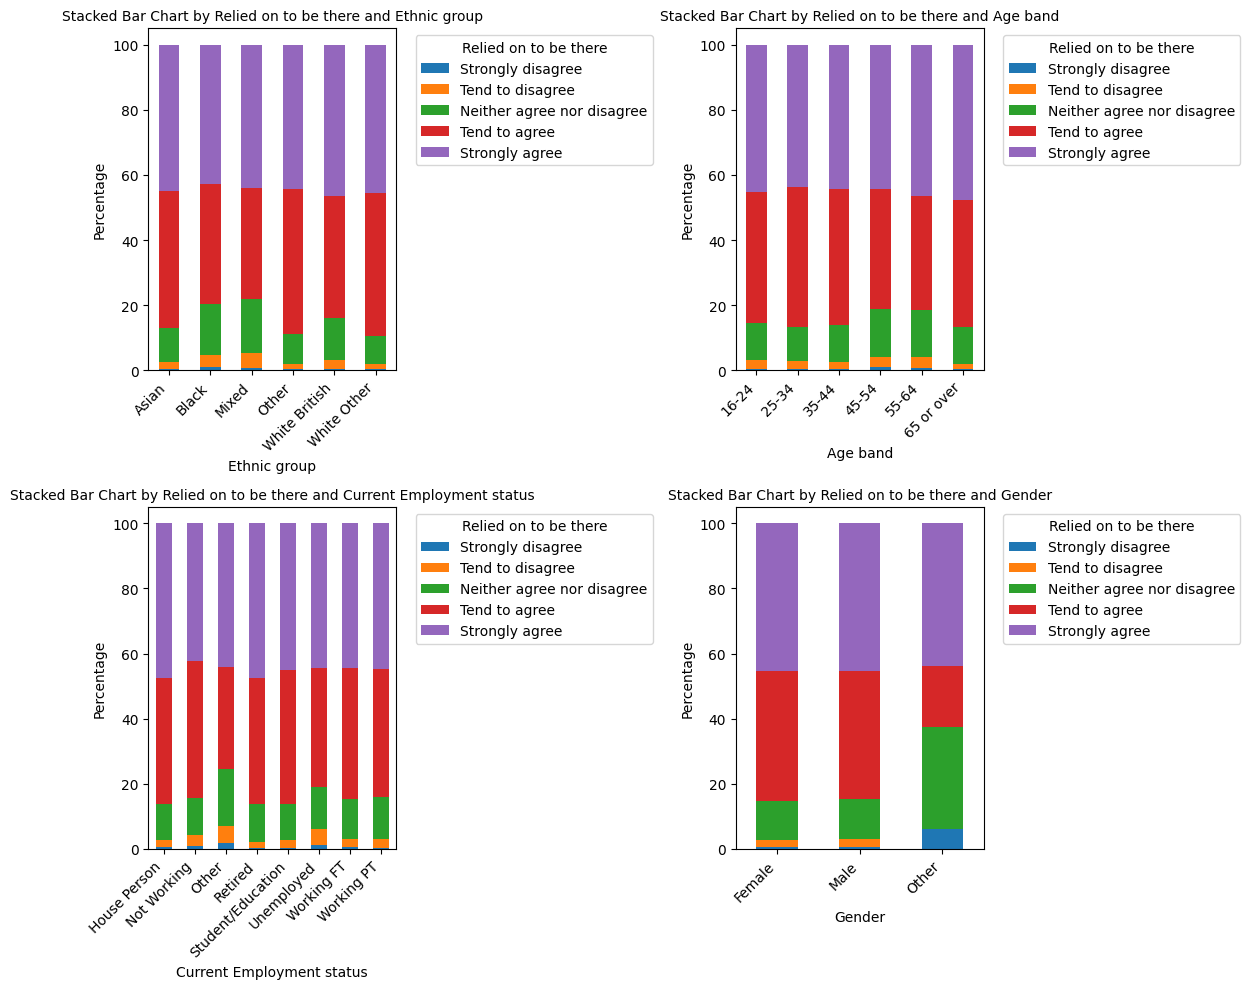

In [176]:
relied_column_order = ['Strongly disagree', 'Tend to disagree','Neither agree nor disagree', 'Tend to agree', 'Strongly agree']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

# Iterate over demographic columns and plot each on a different subplot
for i, demographic in enumerate(demographic_columns):
    grouped = relied_df.groupby([demographic, 'Relied on to be there']).size().unstack(fill_value=0)
    grouped = grouped.reindex(columns=relied_column_order, fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
    ax = grouped.plot(kind='bar', stacked=True, ax=axes[i])  # Plot on the i-th subplot
    ax.set_title(f'Stacked Bar Chart by Relied on to be there and {demographic}', fontsize=10)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')
    ax.legend(title='Relied on to be there', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

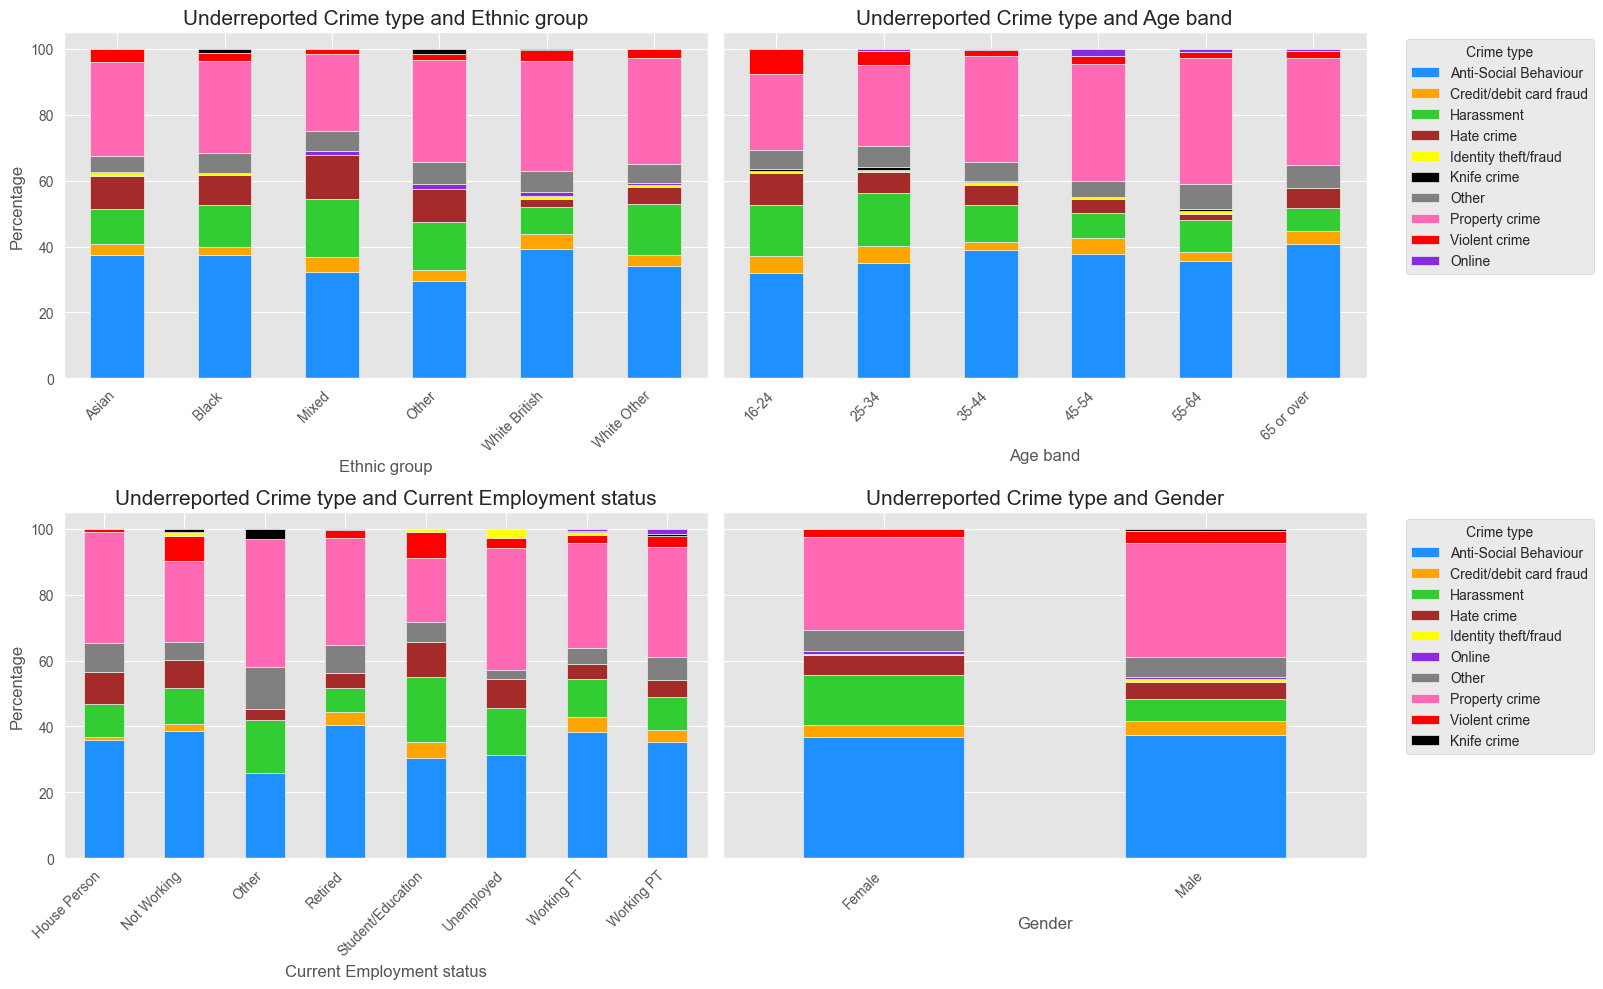

In [355]:
fig, axes = plt.subplots(2, 2, figsize=(19, 10), sharey=True)  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]

colors = {
    'Property crime': '#FF69B4',        # Hot Pink
    'Anti-Social Behaviour': '#1E90FF',  # Dodger Blue
    'Other': '#808080',                 # Gray
    'Harassment': '#32CD32',             # Lime Green
    'Online': '#8A2BE2',                 # Blue Violet
    'Violent crime': '#FF0000',          # Red
    'Credit/debit card fraud': '#FFA500', # Orange
    'Hate crime': '#A52A2A',             # Brown
    'Identity theft/fraud': '#FFFF00',   # Yellow
    'Knife crime': '#000000',            # Black
    'Identity theft': '#00FFFF'          # Cyan
}


df_1621.loc[df_1621['Crime type'] == 'Online contact that has caused fear, alarm or distress', 'Crime type'] = 'Online'
df_1621.loc[df_1621['Crime type'] == 'Knife crime - being threatened with a knife or attacked with a knife', 'Crime type'] = 'Knife crime'
df_1621.loc[df_1621['Crime type'] == 'Credit/debit card fraud', 'Crime type'] = 'Credit/debit card fraud'
# Iterate over demographic columns and plot each on a different subplot
for i, demographic in enumerate(demographic_columns):
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
    ax = grouped.plot(kind='bar', stacked=True, ax=axes[i], legend=False, color=colors)  # Plot on the i-th subplot
    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')
    if i in [1,3]:
        ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

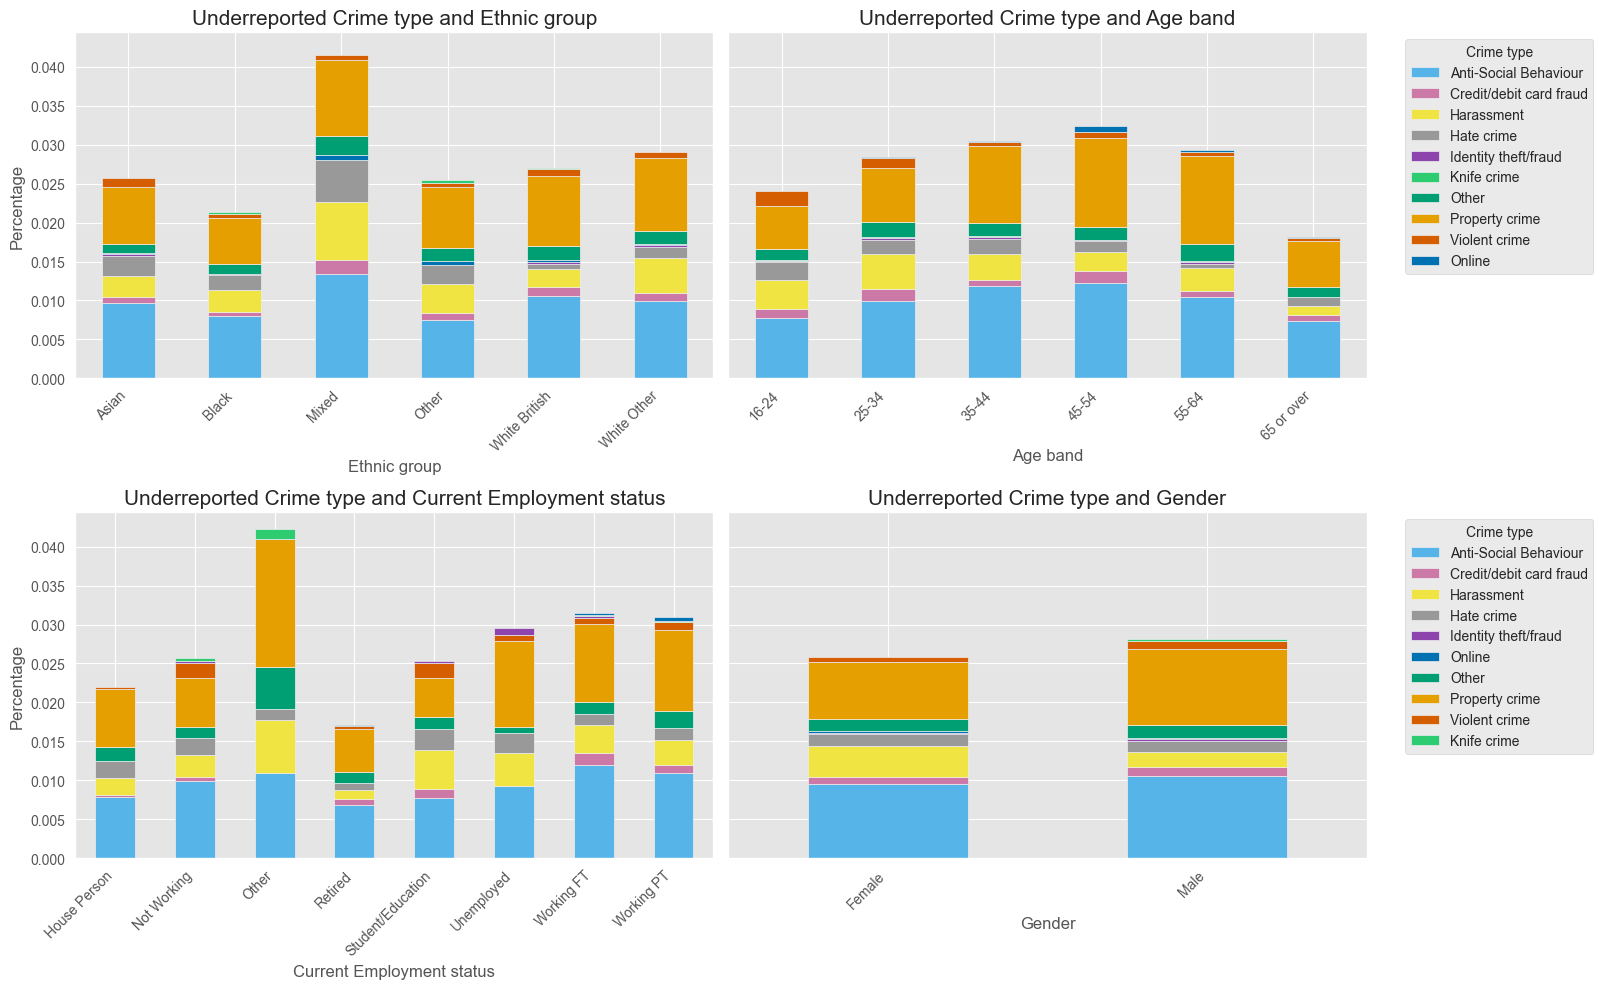

In [453]:
fig, axes = plt.subplots(2, 2, figsize=(19, 10), sharey=True)  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)]

colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}


df_1621.loc[df_1621['Crime type'] == 'Online contact that has caused fear, alarm or distress', 'Crime type'] = 'Online'
df_1621.loc[df_1621['Crime type'] == 'Knife crime - being threatened with a knife or attacked with a knife', 'Crime type'] = 'Knife crime'
df_1621.loc[df_1621['Crime type'] == 'Credit/debit card fraud', 'Crime type'] = 'Credit/debit card fraud'
# Iterate over demographic columns and plot each on a different subplot
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(demographic_df, axis=0)
    grouped = grouped.dropna(how='all')
    ax = grouped.plot(kind='bar', stacked=True, ax=axes[i], legend=False, color=colors)  # Plot on the i-th subplot
    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')
    if i in [1,3]:
        ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

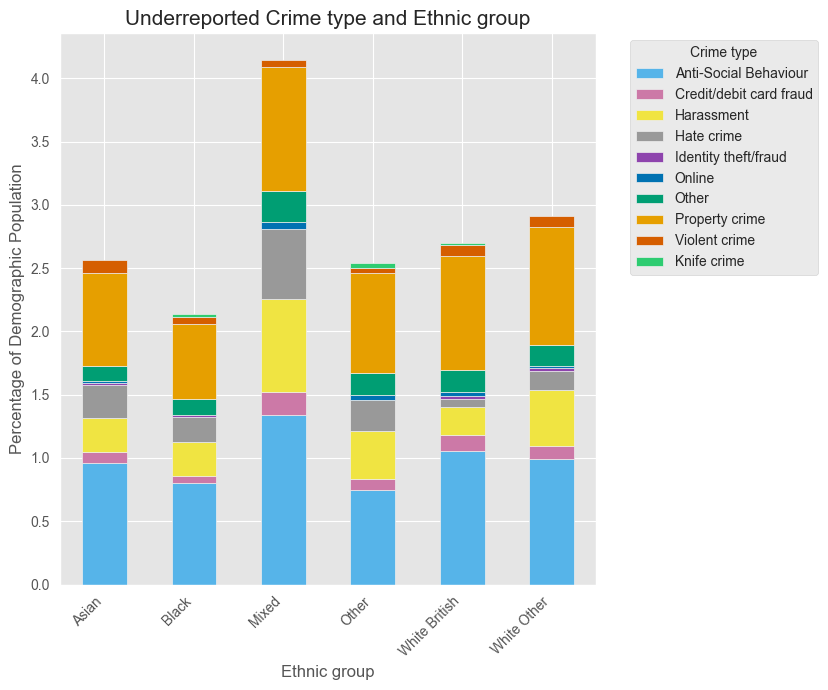

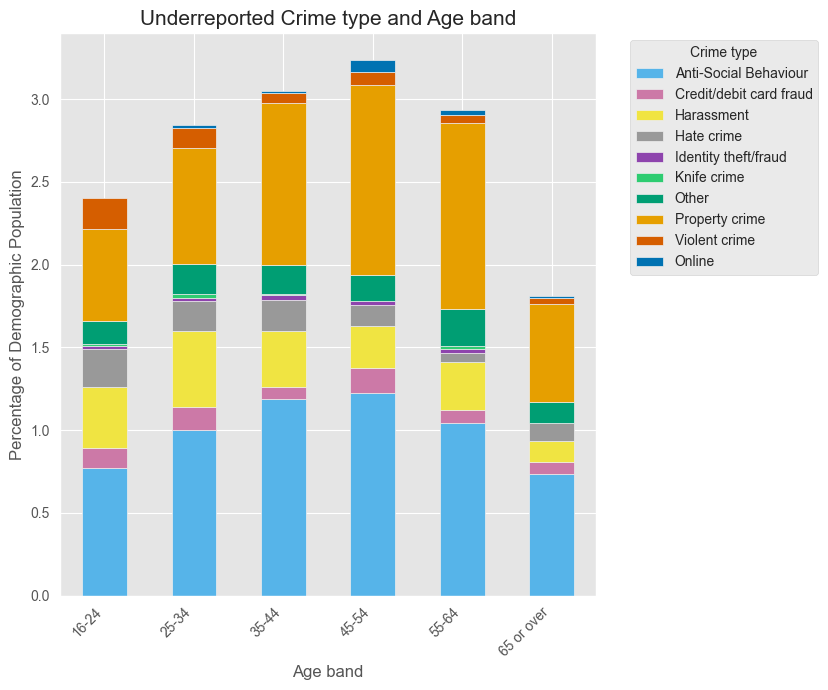

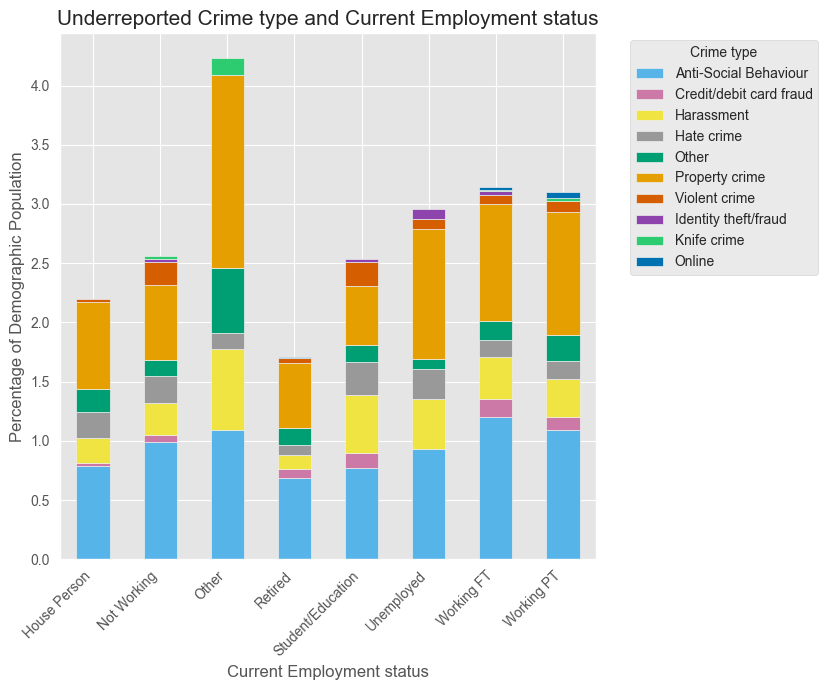

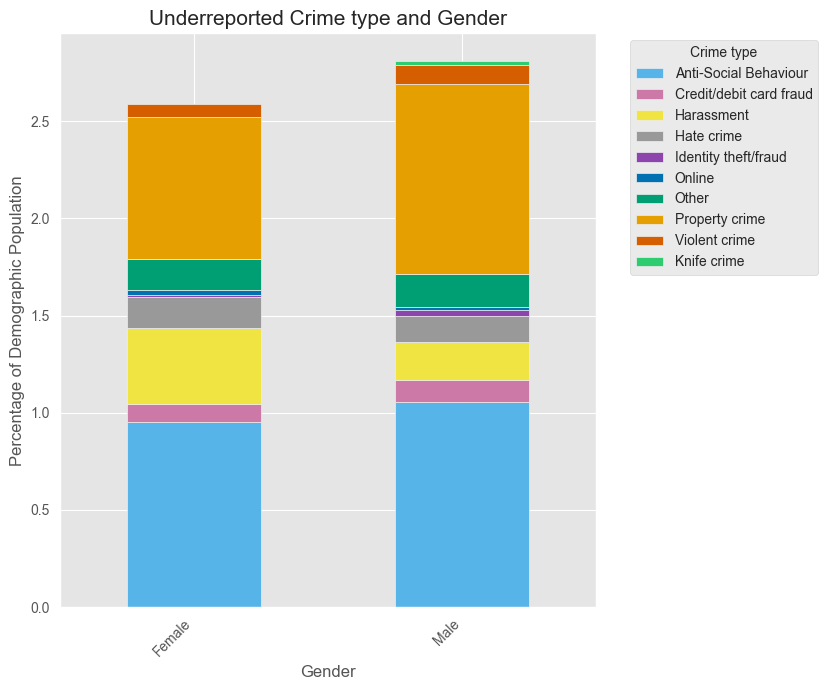

In [452]:
colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}
# were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes'])]

# Filter the DataFrame for the years 2016 to 2021
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)].copy()

# Standardize the 'Crime type' column
df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online contact that has caused fear, alarm or distress': 'Online',
    'Knife crime - being threatened with a knife or attacked with a knife': 'Knife crime',
    'Credit/debit card fraud': 'Credit/debit card fraud'
})

# Iterate over demographic columns and plot each on a different figure
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(demographic_df, axis=0)*100
    grouped = grouped.dropna(how='all')

    # Create a new figure for each demographic
    fig, ax = plt.subplots(figsize=(10, 7))
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in grouped.columns])

    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage of Demographic Population')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

    # Add the legend
    ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim([0,12])
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    plt.savefig(f"demographicstackedoftotal{i}.png", transparent=True)
    plt.show()

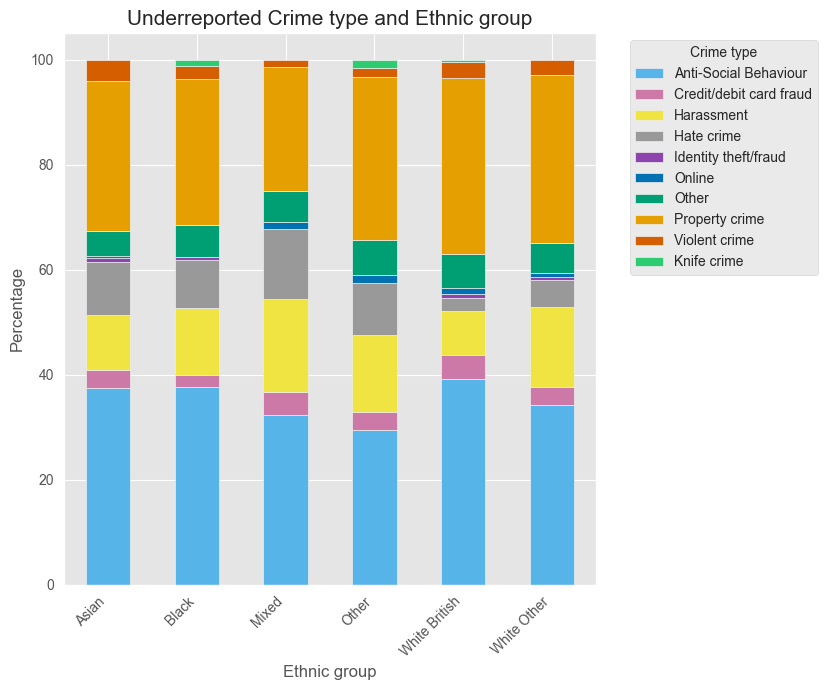

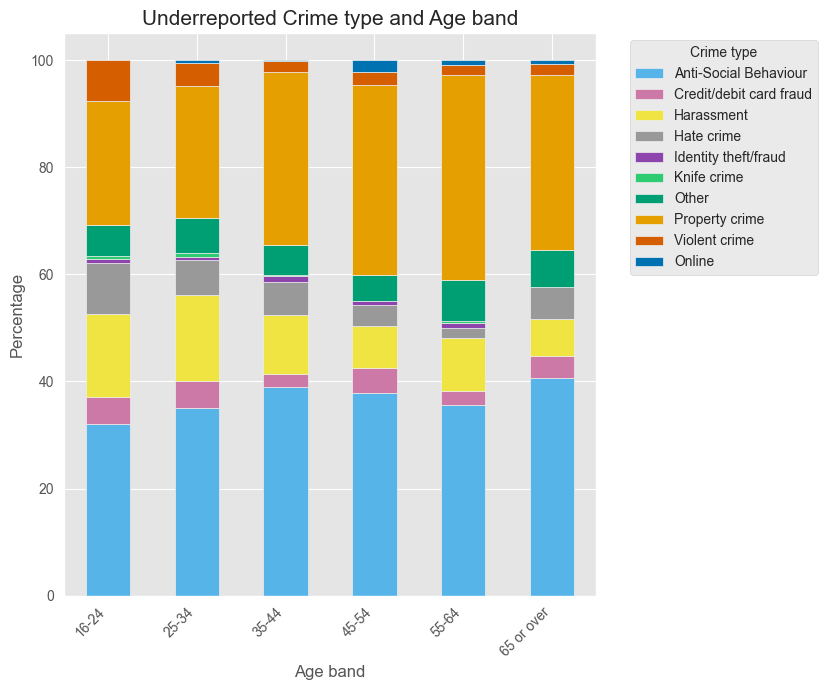

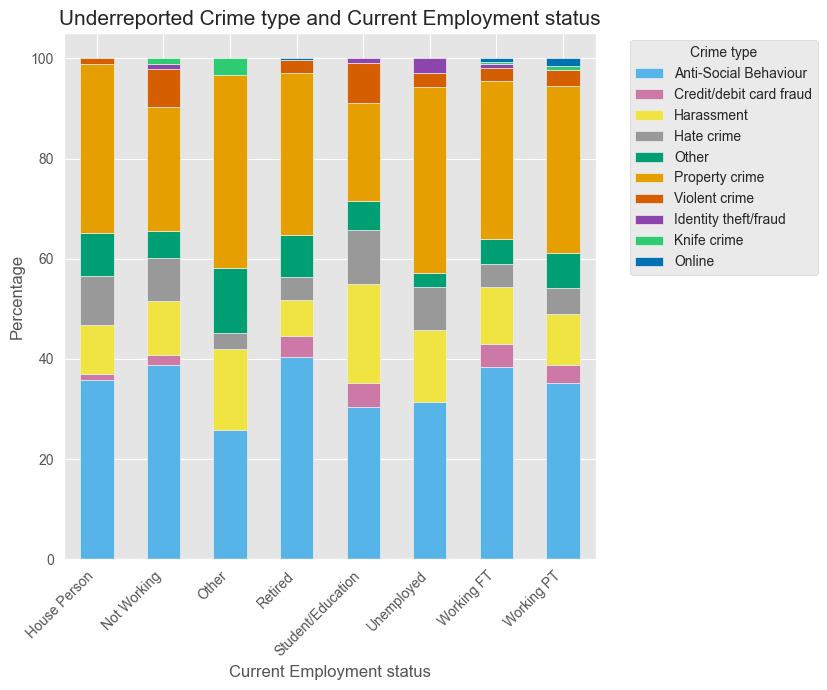

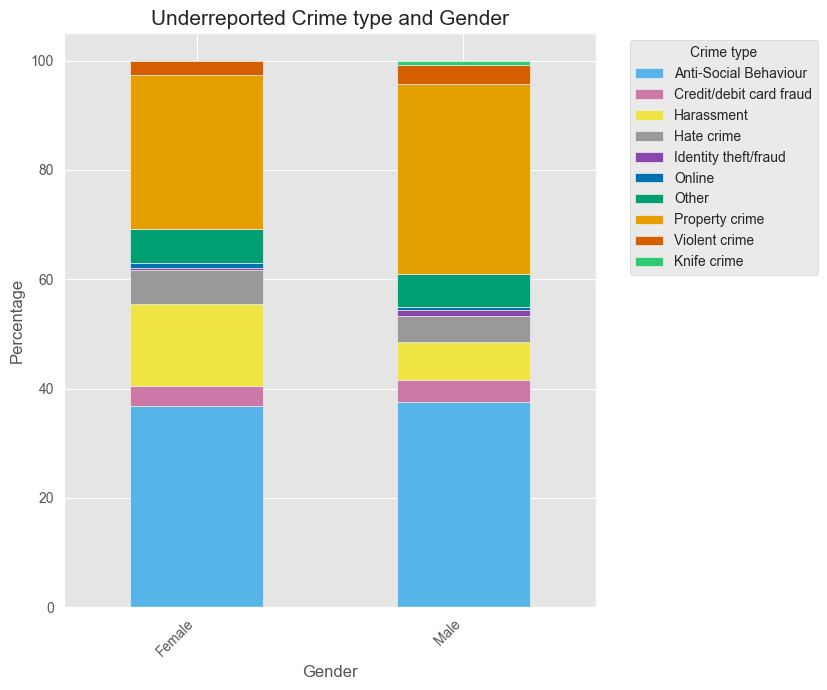

In [454]:
colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}
# were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes'])]

# Filter the DataFrame for the years 2016 to 2021
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)].copy()

# Standardize the 'Crime type' column
df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online contact that has caused fear, alarm or distress': 'Online',
    'Knife crime - being threatened with a knife or attacked with a knife': 'Knife crime',
    'Credit/debit card fraud': 'Credit/debit card fraud'
})

# Iterate over demographic columns and plot each on a different figure
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Create a new figure for each demographic
    fig, ax = plt.subplots(figsize=(10, 7))
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in grouped.columns])

    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

    # Add the legend
    ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim([0,12])
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    plt.savefig(f"demographicstacked{i}.png", transparent=True)
    plt.show()

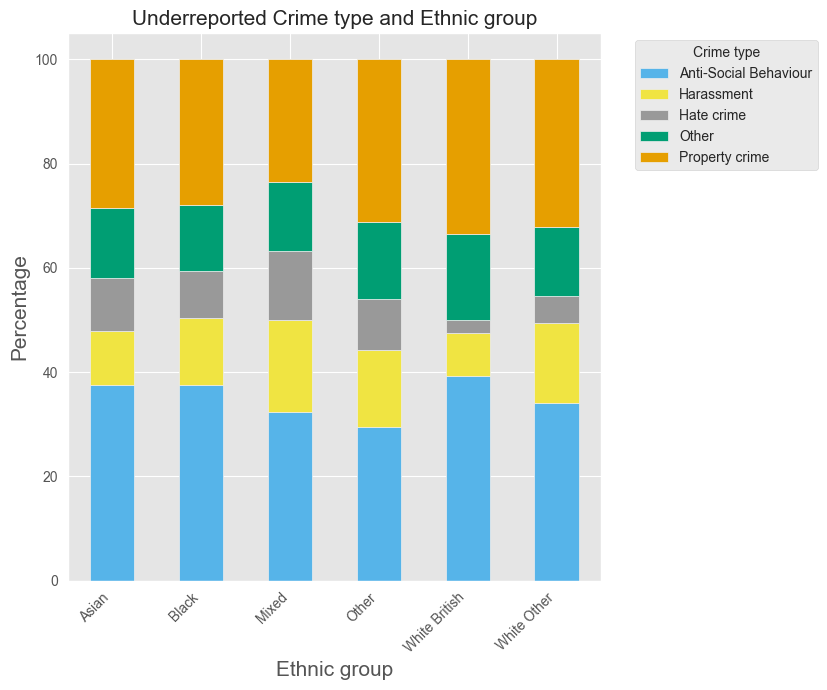

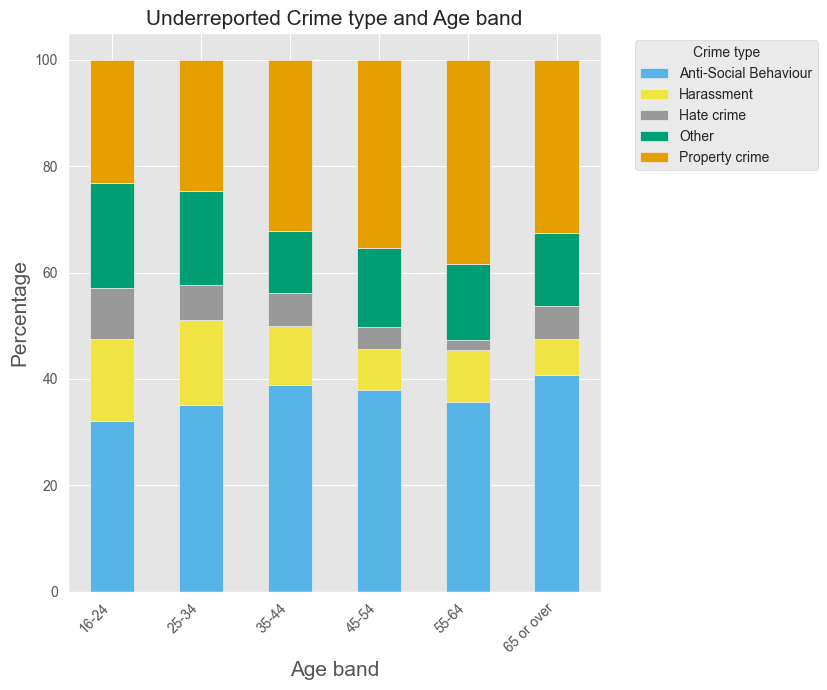

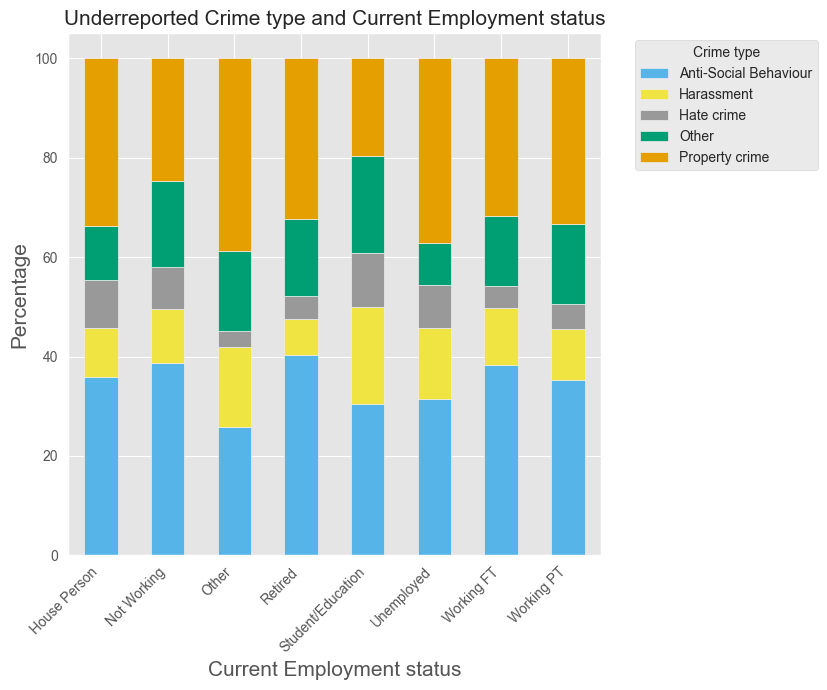

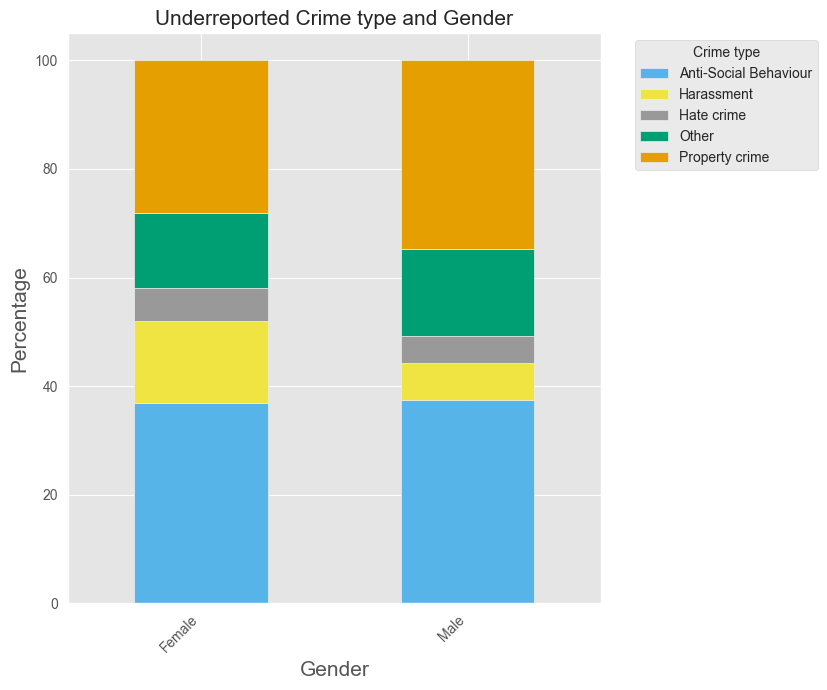

In [459]:
colors = {
    'Property crime': '#E69F00',        # Orange
    'Anti-Social Behaviour': '#56B4E9', # Sky Blue
    'Other': '#009E73',                 # Green
    'Harassment': '#F0E442',            # Yellow
    'Online': '#0072B2',                # Blue
    'Violent crime': '#D55E00',         # Vermilion
    'Credit/debit card fraud': '#CC79A7', # Reddish Purple
    'Hate crime': '#999999',            # Gray
    'Identity theft/fraud': '#8E44AD',  # Purple
    'Knife crime': '#2ECC71',           # Emerald
    'Identity theft': '#FF6347'         # Tomato
}
# were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes'])]

# Filter the DataFrame for the years 2016 to 2021
df_1621 = df_1521[(df_1521['Year'] > 2015) & (df_1521['Year'] < 2022)].copy()

# Standardize the 'Crime type' column
df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online contact that has caused fear, alarm or distress': 'Online',
    'Knife crime - being threatened with a knife or attacked with a knife': 'Knife crime',
    'Credit/debit card fraud ': 'Credit/debit card fraud'
})


df_1621['Crime type'] = df_1621['Crime type'].replace({
    'Online': 'Other',
    'Violent crime': 'Other',
    'Credit/debit card fraud': 'Other',
    'Identity theft/fraud': 'Other',
    'Knife crime': 'Other',
    'Identity theft': 'Other'
})

# Iterate over demographic columns and plot each on a different figure
for i, demographic in enumerate(demographic_columns):
    demographic_df = PAS_detailed.groupby(demographic).size()
    grouped = df_1621[df_1621['Reported'] == 'No'].groupby([demographic, 'Crime type']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Create a new figure for each demographic
    fig, ax = plt.subplots(figsize=(10, 7))
    grouped.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in grouped.columns])

    ax.set_title(f'Underreported Crime type and {demographic}', fontsize=15)
    ax.set_xlabel(demographic, fontsize=15)
    ax.set_ylabel('Percentage', fontsize=15)
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')

    # Add the legend
    ax.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_ylim([0,12])
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Show the plot
    plt.savefig(f"demographicstacked{i}.png", transparent=True)
    plt.show()

In [439]:
demographic_df

Gender
Female    3683
Male      3093
Other        1
dtype: int64

C:\Users\20221317\AppData\Local\Temp\ipykernel_24068\2440681738.py:9: FutureWarning: The provided callable <function sum at 0x0000021E4ED66EE0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot = grouped.pivot_table(index=['Age band', 'Crime type'], columns='Reported', values='count', fill_value=0, aggfunc=np.sum)


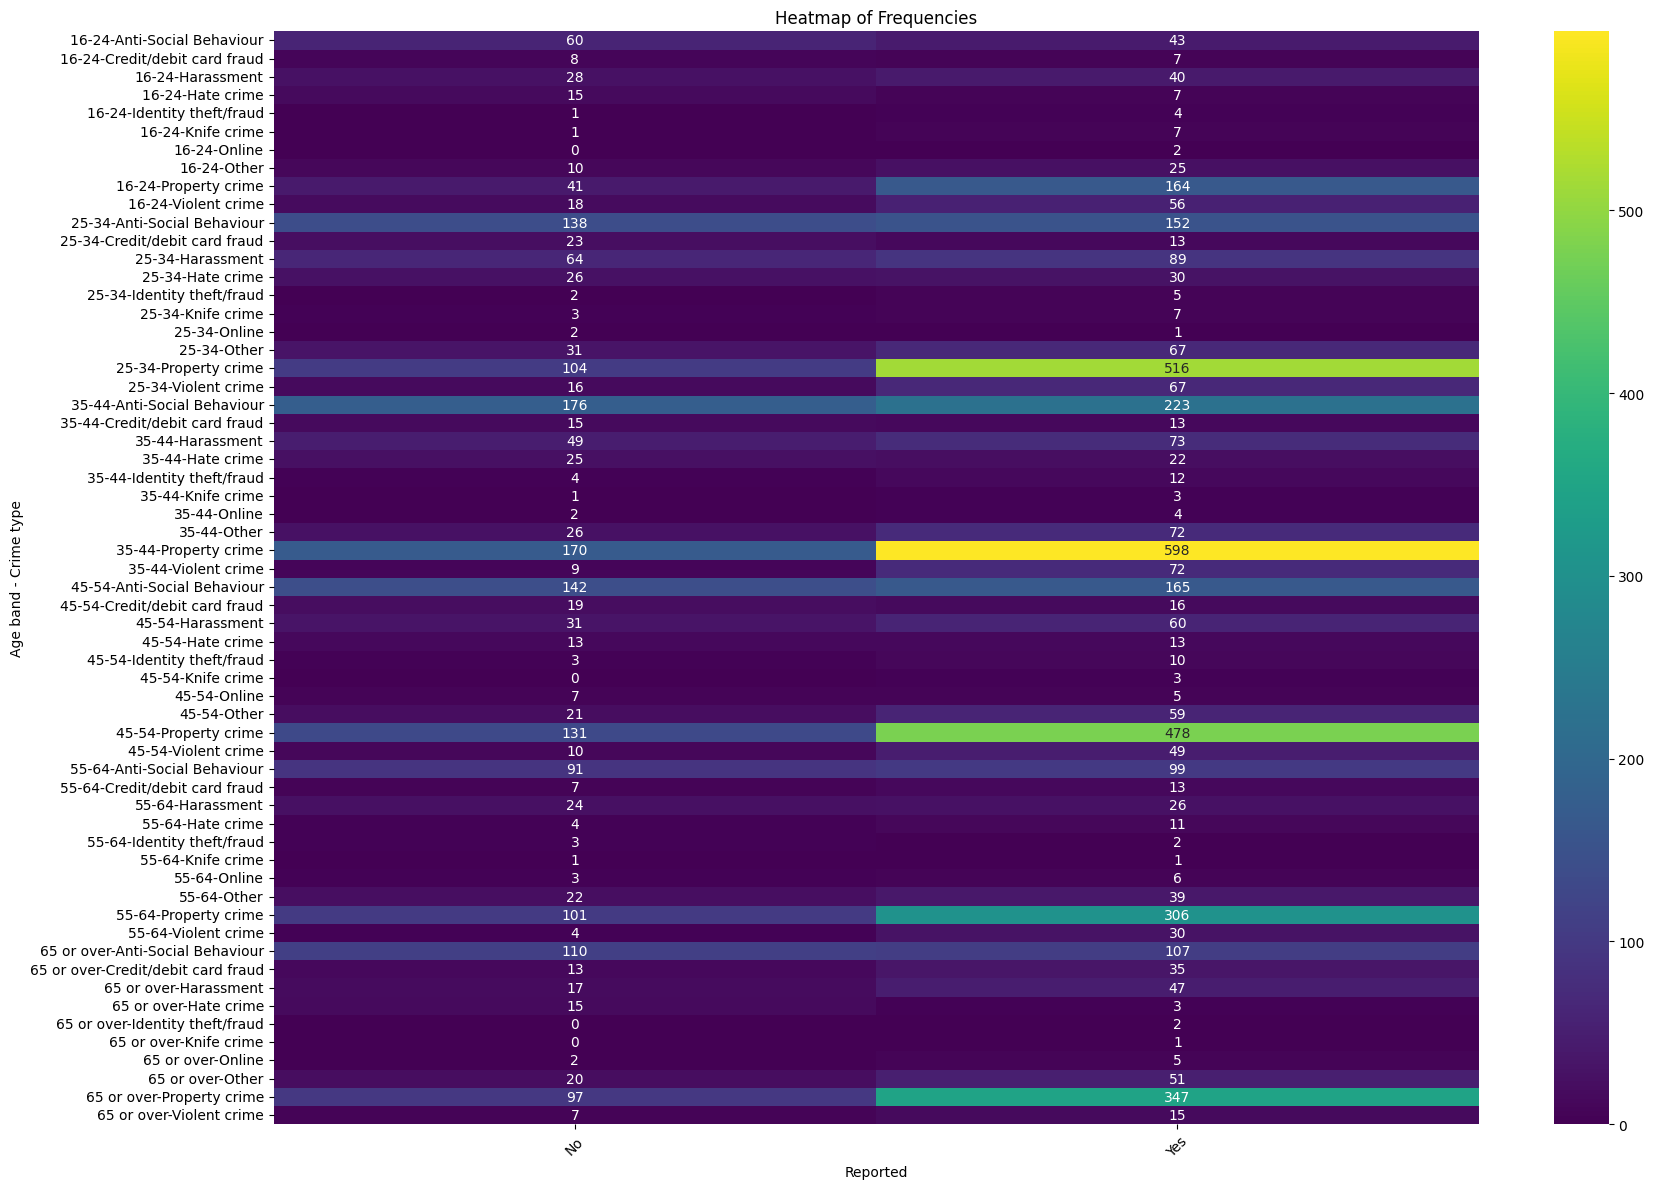

In [216]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Group by the three categorical variables and calculate the frequency
grouped = df_1521.groupby(['Age band', 'Crime type', 'Reported']).size().reset_index(name='count')

# Create a pivot table for heatmap
pivot = grouped.pivot_table(index=['Age band', 'Crime type'], columns='Reported', values='count', fill_value=0, aggfunc=np.sum)

# Plot
plt.figure(figsize=(18, 12))
sns.heatmap(pivot, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Frequencies')
plt.xlabel('Reported')
plt.ylabel('Age band - Crime type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


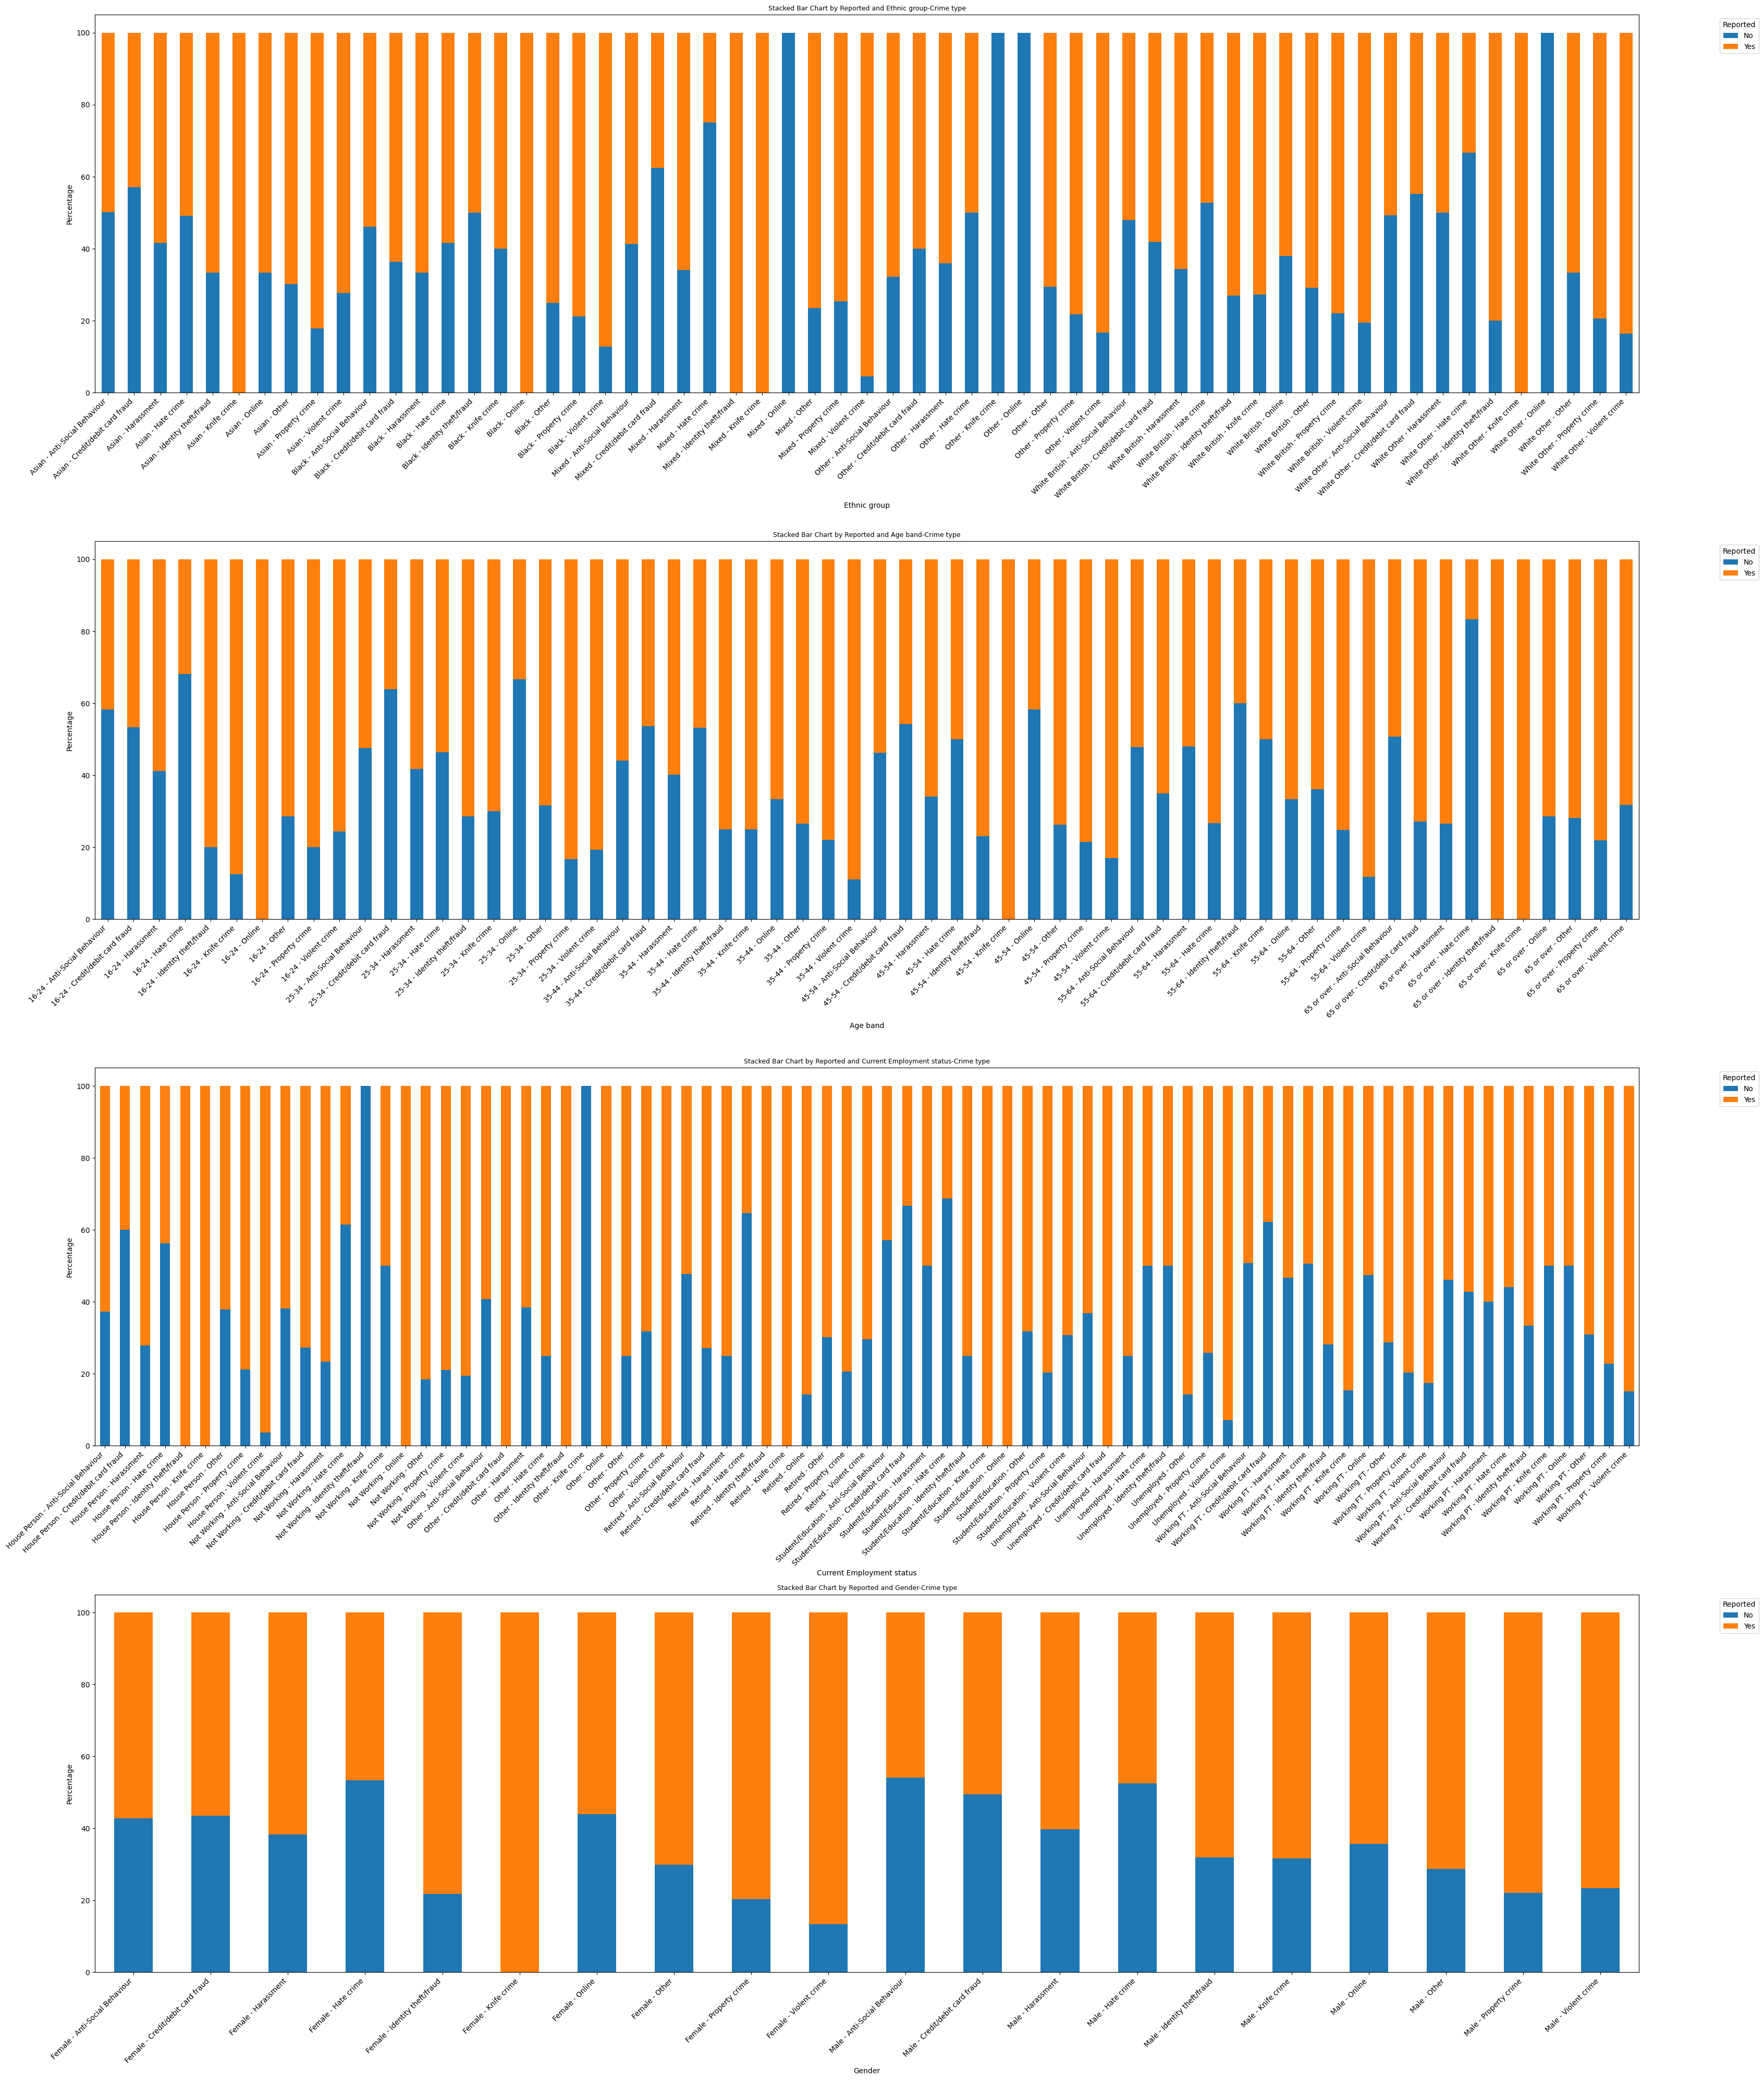

In [219]:
fig, axes = plt.subplots(4, 1, figsize=(40, 40), sharey=True)  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easy iteration

# Iterate over demographic columns and plot each on a different subplot
for i, demographic in enumerate(demographic_columns):
    df_1521[f'{demographic}-Crime type'] = df_1521[demographic] + ' - ' + df_1521['Crime type']
    grouped = df_1521.groupby([f'{demographic}-Crime type', 'Reported']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0) * 100
    ax = grouped.plot(kind='bar', stacked=True, ax=axes[i], legend=False)  # Plot on the i-th subplot
    ax.set_title(f'Stacked Bar Chart by Reported and {demographic}-Crime type', fontsize=9)
    ax.set_xlabel(demographic)
    ax.set_ylabel('Percentage')
    ax.set_xticks(ax.get_xticks(), grouped.index, rotation=45, ha='right')
    ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [198]:
l = []
for crt in df_1521['Crime type'].unique():
    if len(crt)>20:
        l.append(crt)

<Axes: xlabel='Age band', ylabel='Crime type'>

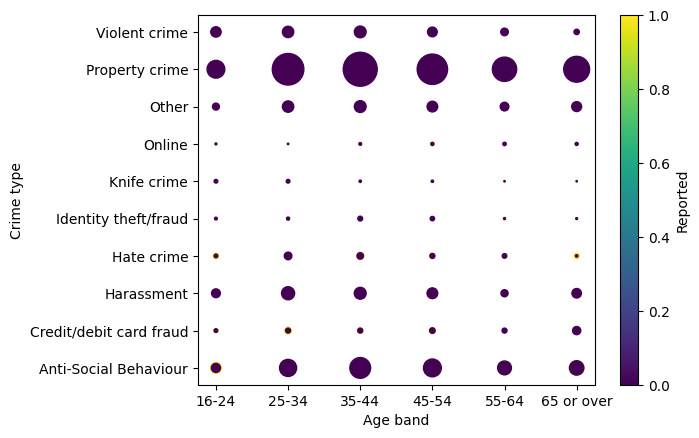

In [236]:
d = df_1521.groupby([f'Age band','Crime type', 'Reported']).size().reset_index(name='count')
d['Reported'] = d['Reported'].map({'Yes':0, 'No':1})
d.plot(kind='scatter', x='Age band', y='Crime type', s = 'count', c='Reported', cmap='viridis')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


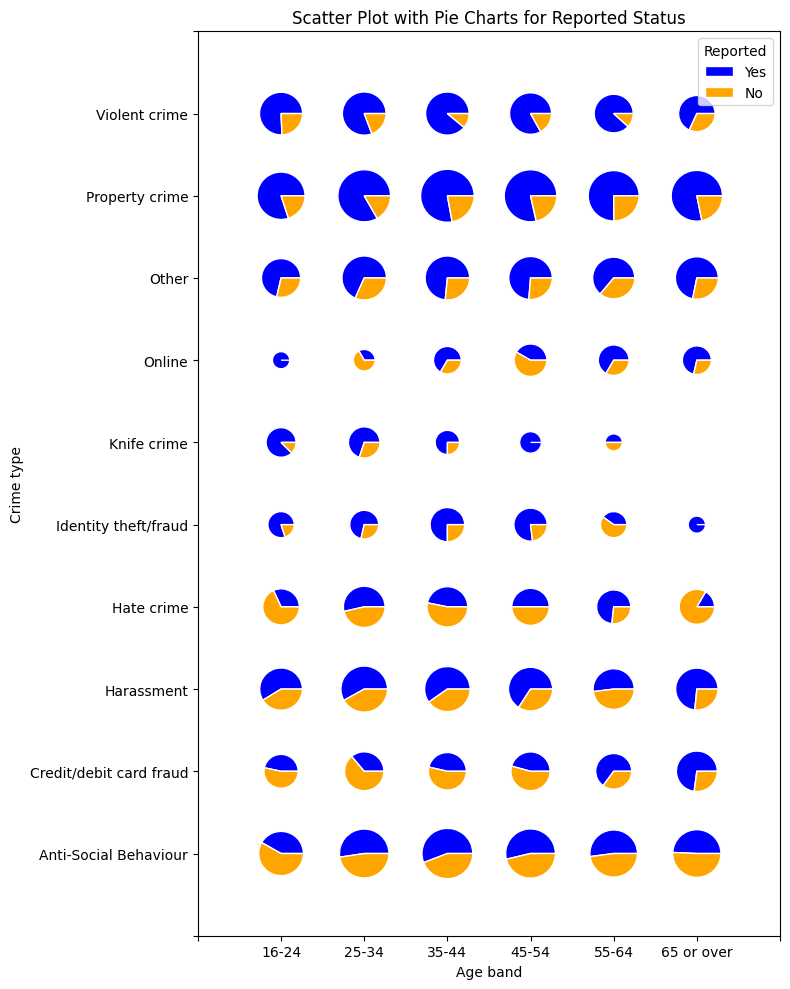

In [274]:
from matplotlib.patches import Wedge,Patch


# Assuming df is your DataFrame
# Group by 'Age band' and 'Crime type', and count occurrences of 'Reported'
grouped = df_1521.groupby(['Age band', 'Crime type', 'Reported']).size().unstack(fill_value=0).reset_index()

# Define unique values for Age band and Crime type
age_bands = grouped['Age band'].unique()
crime_types = grouped['Crime type'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Define colors for 'Yes' and 'No'
colors = {'Yes': 'blue', 'No': 'orange'}

# Function to draw a pie chart at a specific location
def draw_pie(ax, ratios, x, y, size):
    """Draw a pie chart on an axis."""
    start_angle = 0
    for i, ratio in enumerate(ratios):
        angle = 360 * ratio
        ax.add_patch(Wedge((x, y), size, start_angle, start_angle + angle, facecolor=colors[list(ratios.keys())[i]], edgecolor='white'))
        start_angle += angle

# Loop through each combination of Age band and Crime type
for _, row in grouped.iterrows():
    x = np.where(age_bands == row['Age band'])[0][0] + 1  # Add 1 for the gap
    y = np.where(crime_types == row['Crime type'])[0][0] + 1  # Add 1 for the gap
    total = row[['Yes', 'No']].sum()
    if total > 0:
        ratios = row[['Yes', 'No']] / total
        draw_pie(ax, ratios, x, y, np.sqrt(np.log(total)) / 8)  # Adjust size based on total

# Set axis labels and titles
ax.set_xticks(range(0, len(age_bands) + 2))  # +2 to include the gap
ax.set_xticklabels([''] + list(age_bands) + [''])
ax.set_yticks(range(0, len(crime_types) + 2))  # +2 to include the gap
ax.set_yticklabels([''] + list(crime_types) + [''])
ax.set_xlabel('Age band')
ax.set_ylabel('Crime type')
ax.set_title('Scatter Plot with Pie Charts for Reported Status')
ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')
# Set limits to ensure gaps at the start and end
ax.set_xlim(0, len(age_bands) + 1)
ax.set_ylim(0, len(crime_types) + 1)
legend_elements = [Patch(facecolor=colors['Yes'], edgecolor='white', label='Yes'),
                   Patch(facecolor=colors['No'], edgecolor='white', label='No')]
ax.legend(handles=legend_elements, title='Reported', loc='upper right')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


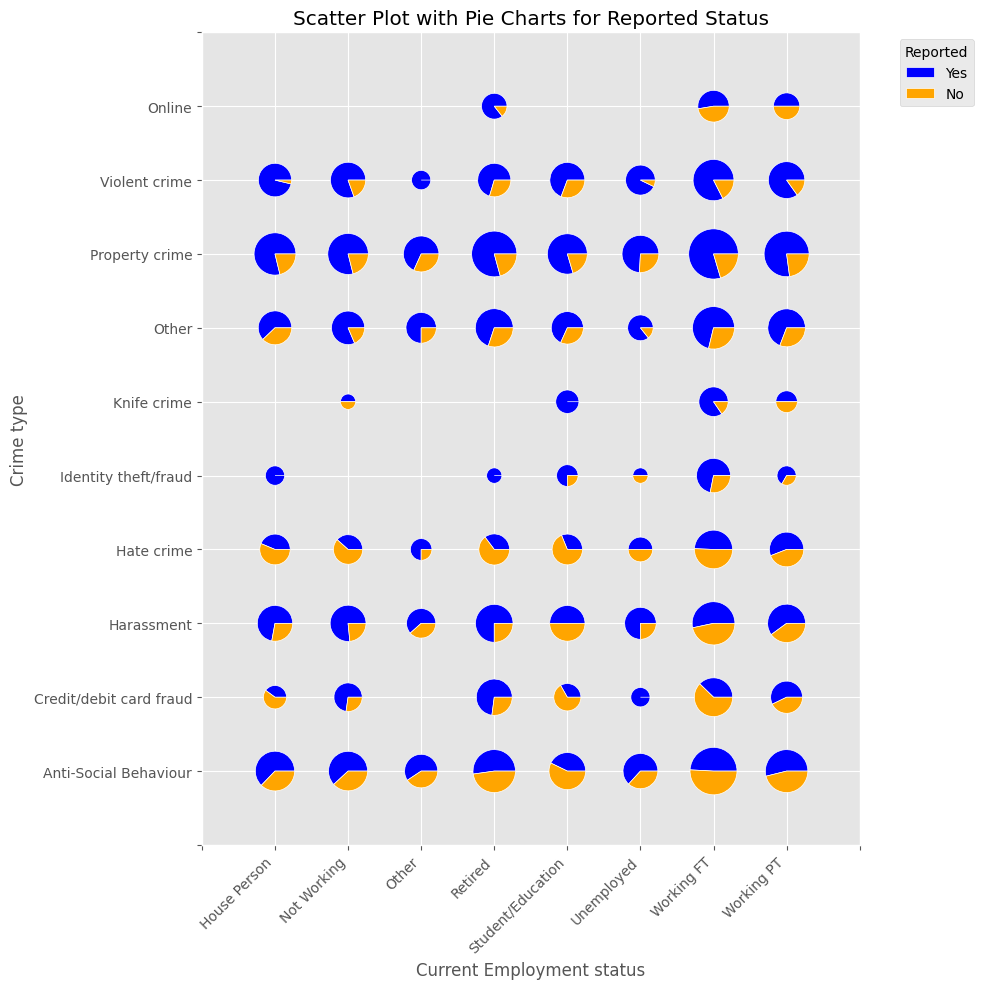

In [337]:
from matplotlib.patches import Wedge,Patch


# Assuming df is your DataFrame
# Group by 'Age band' and 'Crime type', and count occurrences of 'Reported'
demographic = demographic_columns[2]
grouped = df_1521.groupby([demographic, 'Crime type', 'Reported']).size().unstack(fill_value=0).reset_index()

# Define unique values for Age band and Crime type
age_bands = grouped[demographic].unique()
crime_types = grouped['Crime type'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Define colors for 'Yes' and 'No'
colors = {'Yes': 'blue', 'No': 'orange'}

# Function to draw a pie chart at a specific location
def draw_pie(ax, ratios, x, y, size):
    """Draw a pie chart on an axis."""
    start_angle = 0
    for i, ratio in enumerate(ratios):
        angle = 360 * ratio
        ax.add_patch(Wedge((x, y), size, start_angle, start_angle + angle, facecolor=colors[list(ratios.keys())[i]], edgecolor='white'))
        start_angle += angle

# Loop through each combination of Age band and Crime type
for _, row in grouped.iterrows():
    x = np.where(age_bands == row[demographic])[0][0] + 1  # Add 1 for the gap
    y = np.where(crime_types == row['Crime type'])[0][0] + 1  # Add 1 for the gap
    total = row[['Yes', 'No']].sum()
    if total > 0:
        ratios = row[['Yes', 'No']] / total
        draw_pie(ax, ratios, x, y, np.sqrt(np.log(total)) / 8)  # Adjust size based on total

# Set axis labels and titles
ax.set_xticks(range(0, len(age_bands) + 2))  # +2 to include the gap
ax.set_xticklabels([''] + list(age_bands) + [''], rotation = 45, ha='right')
ax.set_yticks(range(0, len(crime_types) + 2))  # +2 to include the gap
ax.set_yticklabels([''] + list(crime_types) + [''])
ax.set_xlabel(demographic)
ax.set_ylabel('Crime type')
ax.set_title('Scatter Plot with Pie Charts for Reported Status')
ax.legend(title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')
# Set limits to ensure gaps at the start and end
ax.set_xlim(0, len(age_bands) + 1)
ax.set_ylim(0, len(crime_types) + 1)
legend_elements = [Patch(facecolor=colors['Yes'], edgecolor='white', label='Yes'),
                   Patch(facecolor=colors['No'], edgecolor='white', label='No')]
ax.legend(handles=legend_elements, title='Reported', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [192]:
df_1521.loc[df_1521['Crime type'] == 'Credit/debit card fraud', 'Crime type'] = 'Credit/debit card fraud'

In [297]:
were_a_victim = PAS_detailed[PAS_detailed['BQ90A'].isin(['Yes', 'No'])]


In [302]:
were_a_victim.groupby('BQ90A').size()['Yes']/were_a_victim.groupby('BQ90A').size().sum()

0.11971812537657507

In [299]:
9140/(67206+9140)

0.11971812537657507